In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

In [146]:
BASE_PATH = "~/Code/FIM-CGRASP/results/"

In [193]:
def create_xtable(dimension, dm_lshade_config):
    lshade_df = pd.read_csv(BASE_PATH + f"/out(--lshade --sf ).csv", sep=";")
    lshade_df = lshade_df[lshade_df.Dim == dimension]
    
    dm_lshade_df = pd.read_csv(BASE_PATH + f"uv={dimension}/out(--dmlshade {dm_lshade_config} ).csv", sep=";")

    with open(f"tables/avg_costs_d{dimension}({dm_lshade_config}).csv", 'w') as tf:
        tf.write("f;LSHADE;DMLSHADE\n")
        for f in range(30):
            tf.write(f"{f+1};{list(lshade_df.AvgFO)[f]};{list(dm_lshade_df.AvgFO)[f]}\n")

def create_xtable_with_stddev(dimension, dm_lshade_config):
    try:
        lshade_df = pd.read_csv(BASE_PATH + f"stats_test_data/out(--lshade --sf ).csv", sep=";")
        lshade_df = lshade_df[lshade_df.f.str.endswith("-"+str(dimension))]
    
        dm_lshade_df = pd.read_csv(BASE_PATH + f"stats_test_data/uv={dimension}/out(--dmlshade {dm_lshade_config} ).csv", sep=";")
    except FileNotFoundError:
        print(f"file not found for D={dimension}")
        return
    
    with open(f"tables/avg_dev_costs_d{dimension}({dm_lshade_config}).csv", 'w') as tf:
        tf.write("f;LSHADE;DMLSHADE\n")
        for f in range(30):
            lshade_mean = np.mean(lshade_df.iloc[f][1:])
            lshade_dev = np.std(lshade_df.iloc[f][1:])
            
            dmlshade_mean = np.mean(dm_lshade_df.iloc[f][1:]) 
            dmlshade_dev = np.std(dm_lshade_df.iloc[f][1:])

            result = f"{f+1};"
            if lshade_mean < dmlshade_mean:
                result += "-" + f"{lshade_mean:.2e} ({lshade_dev:.2e});"
                result += f"{dmlshade_mean:.2e} ({dmlshade_dev:.2e})\n"
            elif lshade_mean > dmlshade_mean:
                result += f"{lshade_mean:.2e} ({lshade_dev:.2e});"
                result += "-" + f"{dmlshade_mean:.2e} ({dmlshade_dev:.2e})\n" 
            else:
                result = f"{f+1};{lshade_mean:.2e} ({lshade_dev:.2e});{dmlshade_mean:.2e} ({dmlshade_dev:.2e})\n"
            
            tf.write(result)

def bold(text):
    return "\\textbf{" + text + "}"

def mark(text):
    return text + "*"

def is_different(sample1, sample2):
    stat, p = wilcoxon(sample1, sample2, zero_method="zsplit", )
    return p <= 0.05

def create_xtable_results(dimension, dm_lshade_config):
    try:
        lshade_df = pd.read_csv(BASE_PATH + f"stats_test_data/out(--lshade --sf ).csv", sep=";")
        lshade_df = lshade_df[lshade_df.f.str.endswith("-"+str(dimension))]

        tlshade_df = pd.read_csv(BASE_PATH + "out(--lshade --sf ).csv", sep=";")
        tlshade_df = tlshade_df[tlshade_df.Dim == dimension]
    
        dm_lshade_df = pd.read_csv(BASE_PATH + f"stats_test_data/uv={dimension}/out(--dmlshade {dm_lshade_config} ).csv", sep=";")
        tdm_lshade_df = pd.read_csv(BASE_PATH + f"uv={dimension}/out(--dmlshade {dm_lshade_config} ).csv", sep=";")
    except FileNotFoundError:
        print(f"file not found for D={dimension}")
        return

    count_wins = 0
    count_swins = 0
    count_bwins = 0
    count_twins = 0

    count_defeats = 0
    count_sdefeats = 0
    count_bdefeats = 0
    count_tdefeats = 0
    
    avg_time_gap = 0.0
    avg_cost_gap = 0.0
    
    with open(f"tables/avg_costs_times_d{dimension}({dm_lshade_config}).csv", 'w') as tf:
        tf.write("f;LSHADE;;;;DMLSHADE;;;\n")
        tf.write("f;Best Cost;Avg. Cost;Avg. Time(s);; Best Cost;Avg. Cost;Avg. Time(s); Time Gap\n")
        for f in range(30):
            # statistics:
            lshade_best = np.min(lshade_df.iloc[f][1:])
            lshade_mean = np.mean(lshade_df.iloc[f][1:])
            lshade_dev = np.std(lshade_df.iloc[f][1:])
            lshade_time = tlshade_df.Time.iloc[f]
            
            dm_lshade_best = np.min(dm_lshade_df.iloc[f][1:])
            dm_lshade_mean = np.mean(dm_lshade_df.iloc[f][1:]) 
            dm_lshade_dev = np.std(dm_lshade_df.iloc[f][1:])
            dm_lshade_time = tdm_lshade_df.Time.iloc[f]

            # gaps:
            time_gap = 100 * ((dm_lshade_time - lshade_time) / lshade_time)

            if lshade_mean == 0:
                cost_gap = 100 * dm_lshade_mean
            else:
                cost_gap = 100 * (float(dm_lshade_mean - lshade_mean) / float(lshade_mean))

            avg_time_gap += time_gap
            avg_cost_gap += cost_gap

            # count wins: 
            avg_winner = ""
            bst_winner = ""
            tme_winner = ""
            
            better_mean = False
            better_min = False
            better_time = False
            issign = False

            if lshade_best > dm_lshade_best:
                bst_winner = "dm"
                count_bwins += 1
                better_min = True

            if lshade_best < dm_lshade_best:
                bst_winner = "ls"
                count_bdefeats += 1
            
            if lshade_mean > dm_lshade_mean: 
                avg_winner = "dm"
                count_wins += 1
                better_mean = True

                if is_different(lshade_df.iloc[f][1:], dm_lshade_df.iloc[f][1:]):
                    count_swins += 1
                    issign = True

            if lshade_mean < dm_lshade_mean:
                avg_winner = "ls"
                count_defeats += 1

                if is_different(lshade_df.iloc[f][1:], dm_lshade_df.iloc[f][1:]):
                    count_sdefeats += 1
                    issign = True

            if lshade_time > dm_lshade_time:
                tme_winner = "dm"
                count_twins += 1
                better_time = True

            if lshade_time < dm_lshade_time:
                tme_winner = "ls"
                count_tdefeats += 1
                
            # build result string:
            result =  f"{f+1};"

            ## lshade best
            if bst_winner == "ls":
                result += bold(f"{lshade_best:.2e}")
            else:
                result += f"{lshade_best:.2e}"

            result += ";"

            ## lshade mean:
            if avg_winner == "ls":
                result += bold(f"{lshade_mean:.2e}")
                if issign:
                    result += "*"
            else:
                result += f"{lshade_mean:.2e}"

            result += ";"

            ## lshade time:
            if tme_winner == "ls":
                result += bold(f"{lshade_time:.4e}")
            else:
                result += f"{lshade_time:.4e}"

            result += ";;"

            ## dm-lshade best
            if bst_winner == "dm":
                result += bold(f"{dm_lshade_best:.2e}")
            else:
                result += f"{dm_lshade_best:.2e}"

            result += ";"

            ## dm-lshade mean:
            if avg_winner == "dm":
                result += bold(f"{dm_lshade_mean:.2e}")
                if issign:
                    result += "*"
            else:
                result += f"{dm_lshade_mean:.2e}"

            result += ";"

            ## dm-lshade time:
            if tme_winner == "dm":
                result += bold(f"{dm_lshade_time:.4e}")
            else:
                result += f"{dm_lshade_time:.4e}"

            result += ";"
            result += f"{time_gap:.2f}\n"
            
            tf.write(result)

    avg_time_gap /= 30
    avg_cost_gap /= 30

    print(f"For D={dimension}:\n")
    print(f"L-SHADE = # of wins = {count_defeats} ({count_sdefeats}) | # of bests = {count_bdefeats} | # of fasters = {count_tdefeats}")
    print(f"DM-L-SHADE = # of wins = {count_wins} ({count_swins}) | # of bests = {count_bwins} | # of fasters = {count_twins}")
    print(f"acg = {avg_cost_gap} | atg = {avg_time_gap}\n")

In [194]:
for D in [10, 30, 50, 100]:
    create_xtable_results(D, "--crossgen --insert --rand --er 0.1 --cr 0.1498 --gs 168 --sf")

For D=10:

L-SHADE = # of wins = 5 (0) | # of bests = 1 | # of fasters = 30
DM-L-SHADE = # of wins = 17 (11) | # of bests = 14 | # of fasters = 0
acg = 0.28096949317615044 | atg = 14.278408693815532

For D=30:

L-SHADE = # of wins = 8 (1) | # of bests = 5 | # of fasters = 30
DM-L-SHADE = # of wins = 14 (9) | # of bests = 13 | # of fasters = 0
acg = -1.0004595155348774 | atg = 5.353554016302288

For D=50:

L-SHADE = # of wins = 8 (1) | # of bests = 4 | # of fasters = 27
DM-L-SHADE = # of wins = 17 (8) | # of bests = 16 | # of fasters = 3
acg = -1.9160524405191575 | atg = 10.139273401439114

For D=100:

L-SHADE = # of wins = 6 (3) | # of bests = 7 | # of fasters = 4
DM-L-SHADE = # of wins = 17 (13) | # of bests = 15 | # of fasters = 26
acg = 3.2280716867155657 | atg = -10.648985632655256



In [139]:
for D in [10, 30, 50, 100]:
    create_xtable_with_stddev(D, "--crossgen --insert --rand --er 0.1 --cr 0.1498 --gs 168 --sf")

In [76]:
for D in [10, 30, 50, 100]:
    create_xtable_with_stddev(D, "--crossgen --insert --er 0.1 --gs 150 --sf")

file not found for D=10
file not found for D=50
file not found for D=100


In [166]:
for D in [10, 30, 50, 100]:
    create_xtable_with_stddev(D, "--crossgen --insert --er 0.1 --cr 0.1296 --gs 70 --sf --no_archive")

file not found for D=100


In [165]:
for D in [10, 30, 50, 100]:
    create_xtable_with_stddev(D, "--crossgen --insert --er 0.1 --gs 150 --sf --no_archive")

file not found for D=100


In [113]:
dimension = 100
dm_lshade_config = "--crossgen --insert --rand --er 0.1 --cr 0.1498 --gs 168 --sf"
dm_lshade_df = pd.read_csv(BASE_PATH + f"uv={dimension}/out(--dmlshade {dm_lshade_config} ).csv", sep=";")

In [114]:
lshade_df = pd.read_csv(BASE_PATH + "out(--lshade --sf ).csv", sep=";")
lshade_df = lshade_df[lshade_df.Dim == dimension]

Text(0.5, 1.0, 'Avg. runtime, all functions, D=100')

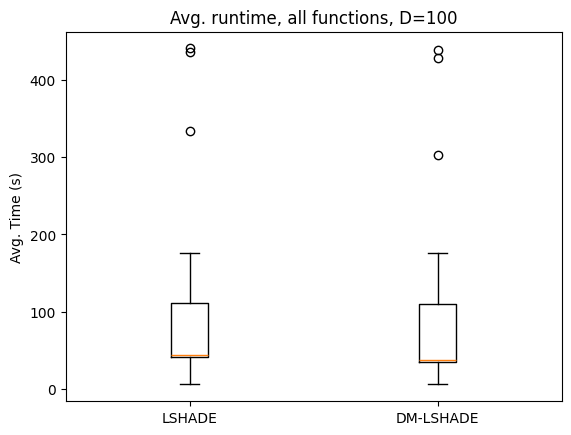

In [115]:
my_dict = {'LSHADE': lshade_df.Time, 'DM-LSHADE': dm_lshade_df.Time}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.set_ylabel("Avg. Time (s)")
ax.set_title(f"Avg. runtime, all functions, D={dimension}")

In [116]:
print(lshade_df.Time.mean())
print(dm_lshade_df.Time.mean())

98.44546999999999
91.99303933333336


In [117]:
print(lshade_df.Time.min())
print(dm_lshade_df.Time.min())

5.8064
5.58308


In [118]:
print(lshade_df.Time.max())
print(dm_lshade_df.Time.max())

440.881
439.317


In [119]:
print(lshade_df.Time.median())
print(dm_lshade_df.Time.median())

43.817750000000004
37.212500000000006


In [120]:
time_diff = [(t1, t2, (t2-t1)/t1) for t1, t2 in zip(lshade_df.Time, dm_lshade_df.Time)]

In [121]:
time_diff 

[(40.5017, 35.0938, -0.1335227904013905),
 (36.0858, 30.5107, -0.15449567419871527),
 (28.568, 23.696, -0.17054046485578267),
 (41.7914, 34.7476, -0.16854663878214188),
 (42.847, 34.2192, -0.201362989240787),
 (333.676, 303.062, -0.09174768338148377),
 (18.0555, 17.4195, -0.03522472376838079),
 (5.8064, 5.58308, -0.03846100854229818),
 (39.4253, 34.82, -0.11681077886534788),
 (11.4525, 10.0915, -0.11883868151058725),
 (48.8689, 40.0182, -0.18111109519551283),
 (129.559, 106.163, -0.18058181986585264),
 (40.8022, 32.3856, -0.20627809284793475),
 (39.7493, 32.8276, -0.17413388411871408),
 (43.1791, 35.535, -0.17703240688203326),
 (44.0318, 35.4354, -0.19523162805063604),
 (44.5877, 37.2473, -0.16462836163336517),
 (42.3168, 35.1868, -0.16849100120992141),
 (105.576, 88.6116, -0.16068424641964082),
 (41.3237, 37.1777, -0.10032983493733622),
 (43.6037, 39.5953, -0.09192797858897299),
 (52.5274, 46.2724, -0.11908070835411619),
 (163.201, 151.273, -0.07308778745228275),
 (82.9399, 80.2899, -

In [122]:
avg_gap = 0
with open(f"tables/avg_time_diff_d{dimension}({dm_lshade_config}).csv", 'a') as tf:
    tf.write("f;LSHADE;DMLSHADE;delta\n")
    print("f;LSHADE;DMLSHADE;delta")
    f=1 
    for (t1, t2, delta) in time_diff:
        result = f"{f};{t1:.4f};{t2:.4f};{delta:.4f}\n"
        print(result)
        tf.write(result)
        f+=1
        avg_gap += delta

avg_gap /= 30
print(avg_gap)

f;LSHADE;DMLSHADE;delta
1;40.5017;35.0938;-0.1335

2;36.0858;30.5107;-0.1545

3;28.5680;23.6960;-0.1705

4;41.7914;34.7476;-0.1685

5;42.8470;34.2192;-0.2014

6;333.6760;303.0620;-0.0917

7;18.0555;17.4195;-0.0352

8;5.8064;5.5831;-0.0385

9;39.4253;34.8200;-0.1168

10;11.4525;10.0915;-0.1188

11;48.8689;40.0182;-0.1811

12;129.5590;106.1630;-0.1806

13;40.8022;32.3856;-0.2063

14;39.7493;32.8276;-0.1741

15;43.1791;35.5350;-0.1770

16;44.0318;35.4354;-0.1952

17;44.5877;37.2473;-0.1646

18;42.3168;35.1868;-0.1685

19;105.5760;88.6116;-0.1607

20;41.3237;37.1777;-0.1003

21;43.6037;39.5953;-0.0919

22;52.5274;46.2724;-0.1191

23;163.2010;151.2730;-0.0731

24;82.9399;80.2899;-0.0320

25;105.7180;111.1970;0.0518

26;436.8950;439.3170;0.0055

27;440.8810;429.1190;-0.0267

28;176.5370;175.5800;-0.0054

29;159.5930;161.6350;0.0128

30;113.2640;115.6810;0.0213

-0.10648985632655256


In [ ]:
0.14278408693815534
0.05353554016302288
0.10139273401439117
-0.10648985632655256